# Exercises - Chapter 03

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATA_PATH = "../data/"

## 3.1

## 3.2

## 3.3

In [15]:
# a) - load labels
labels = pd.read_csv(DATA_PATH + "logBBB.csv")
labels.head()

,x
0,1.08
1,-0.40
2,0.22
3,0.14
4,0.69


In [16]:
# a) - load predictors
predictors = pd.read_csv(DATA_PATH + "bbbDescr.csv")
predictors.head()

,tpsa,nbasic,negative,vsa_hyd,a_aro,weight,peoe_vsa.0,peoe_vsa.1,peoe_vsa.2,peoe_vsa.3,...,scaa3,ctdh,ctaa,mchg,achg,rdta,n_sp2,n_sp3,o_sp2,o_sp3
0,12.030000,1,0,167.06700,0,156.293,76.94749,43.44619,0.00000,0.000000,...,-0.0093,1,1,0.9241,0.9241,1.0000,0.000000,6.0255,0.000000,0.000000
1,49.330002,0,0,92.64243,6,151.165,38.24339,25.52006,0.00000,8.619013,...,-0.0754,2,2,1.2685,1.0420,1.0000,0.000000,6.5681,32.010201,33.613499
2,50.529999,1,0,295.16700,15,366.485,58.05473,124.74020,21.65084,8.619013,...,-0.0303,1,4,1.2562,1.2562,0.2500,26.973301,10.8567,0.000000,27.545099
3,37.389999,0,0,319.11220,15,382.552,62.23933,124.74020,13.19232,21.785640,...,-0.0240,1,3,1.1962,1.1962,0.3333,21.706499,11.0017,0.000000,15.131600
4,37.389999,1,0,299.65800,12,326.464,74.80064,118.04060,33.00190,0.000000,...,-0.0255,1,3,1.2934,1.2934,0.3333,24.206100,10.8109,0.000000,15.133300


In [27]:
# b) - degenerate distributions
# identify any predictors that are low variance (e.g. unique value across all entries, etc.) as potentials for removal
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold()
selection = selector.fit(predictors)

(~(selection.get_support())).sum()

# ==> NONE

0

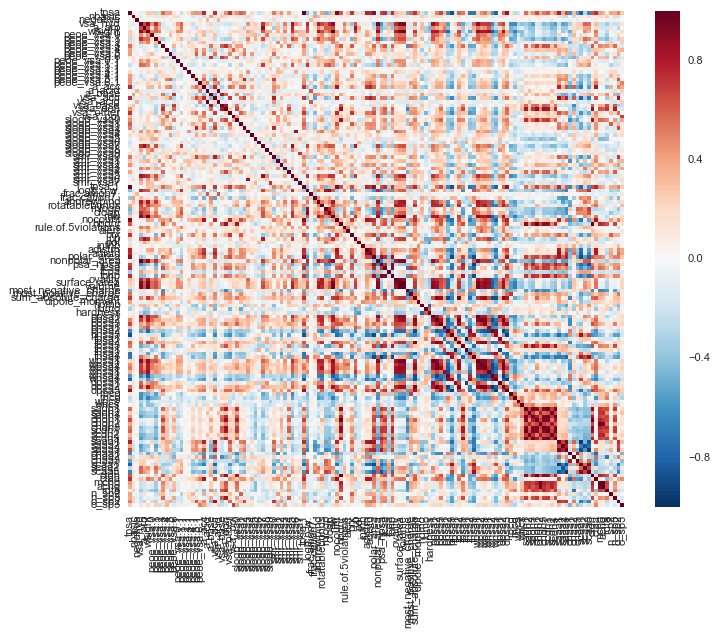

In [28]:
# c) - between predictor correlations
import seaborn as sns
plt.figure(figsize=(10, 8))
correlations = predictors.corr()
sns.heatmap(correlations, 
            xticklabels=correlations.columns.values,
            yticklabels=correlations.columns.values);

In [43]:
def get_feature_correlations(correlations):    
    # look only at the upper triangular values _above_ the main diagonal
    mask = np.triu(np.ones(correlations.shape), k=1).astype(np.bool)
    result = correlations.where(mask).stack().reset_index()
    result.columns = ['featureA', 'featureB', 'corr']
    result['corr_abs'] = np.abs(result['corr'])
    
    return result.sort_values(by='corr_abs', ascending=False)
    
feature_corr = get_feature_correlations(correlations)

In [44]:
def get_most_correlated(feature_corr):
    option1 = feature_corr.iloc[0].featureA
    option2 = feature_corr.iloc[0].featureB
    
    mask1 = (feature_corr.featureA == option1) | (feature_corr.featureB == option1)
    mask2 = (feature_corr.featureA == option2) | (feature_corr.featureB == option2)
    
    # note - in contrast to the caret version, this re-calculates the
    # mean by default with each iteration (without regard to number of predictors)
    mean1 = feature_corr[mask1]['corr_abs'].mean()
    mean2 = feature_corr[mask2]['corr_abs'].mean()
    
    if(mean1 >= mean2):
        return option1
    else:
        return option2

In [45]:
def find_correlations(x, cutoff = 0.9):
    feature_corr = x
    max_cor = feature_corr.iloc[0]['corr_abs']
    to_remove = []
    
    while(max_cor > cutoff):
        feature = get_most_correlated(feature_corr)
        to_remove.append(feature)
        mask = (feature_corr.featureA == feature) | (feature_corr.featureB == feature)
        feature_corr = feature_corr[~mask]
        max_cor = feature_corr.iloc[0]['corr_abs']
        
    return to_remove  

In [56]:
highCorr = find_correlations(feature_corr, cutoff=0.75)
highCorr[:10]

['hbdnr',
 'fnsa1',
 'a_acid',
 'weight',
 'volume',
 'scdh1',
 'mchg',
 'scdh3',
 'tpsa',
 'ppsa2']

In [52]:
predictors.columns.shape

(134,)

In [53]:
len(highCorr)

61

In [54]:
# => yes; there are 19 predictors with r >= 0.95, 44 are >= 0.85, and 61 >= 0.75
# => It could have a dramatic effect on the number of predictors depending on the cutoff chosen for limiting predictors